<a href="https://colab.research.google.com/github/christopher-reed/tidytuesday/blob/master/2021/week_4/TidyTuesday_Kenya_Census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Data

**Google Colab doesn't come with `geopandas` so we use !pip install so it can join the party**

In [1]:
!pip install geopandas

**Packages**

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as clr

**Data**



*   Gender, crops, and household come from TidyTuesday
*   Kenya county shapefile comes from [africaopendata](https://africaopendata.org/dataset/kenya-counties-shapefile)
* African countries comes from `geopandas`



In [3]:
df_gender = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-19/gender.csv')
df_crops = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-19/crops.csv')
df_households = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-19/households.csv')
df_kenya_counties = gpd.read_file('/content/County.shp')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Wrangle

In [4]:
#######################
## CLEAN COLUMN NAMES##
#######################

df_gender.columns = df_gender.columns.str.lower()

df_crops.columns = df_crops.columns.str.lower().str.replace(' ', '_')
df_crops = df_crops.rename(columns = {'subcounty':'county'})

df_households.columns = df_households.columns.str.lower()
df_households = df_households.rename(columns = {'numberofhouseholds':'number_of_households',
                                                'averagehouseholdsize':'average_household_size'})

df_kenya_counties.columns = df_kenya_counties.columns.str.lower()

##############################
## STANDARDIZE COUNTY NAMES ##
##############################

# Base all county names on `df_kenya_counties`
# Can find the counties that don't match the master using the following line
# [x for x in df_to_clean['county'].unique() if x not in df_kenya_counties['county'].unique()]

# Clean df_households
df_households['county'] = df_households['county'].str.replace(' ', '')

df_households['county'] = df_households['county'].replace({'TanaRiver':'Tana River',
                                                           'Taita/Taveta':'Taita Taveta',
                                                           'Tharaka-Nithi':'Tharaka',
                                                           'WestPokot':'West Pokot',
                                                           'TransNzoia':'Trans Nzoia',
                                                           'UasinGishu':'Uasin Gishu',
                                                           'Elgeyo/Marakwet':'Keiyo-Marakwet',
                                                           'NairobiCity':'Nairobi',
                                                           'HomaBay': 'Homa Bay'})

df_households = df_households[df_households['county'] != 'Kenya']

# Clean df_crops
df_crops['county'] = df_crops['county'].str.capitalize()

df_crops['county'] = df_crops['county'].replace({'Tana river':'Tana River',
                                                 'Taita/taveta':'Taita Taveta',
                                                 'Tharaka-nithi':'Tharaka',
                                                 'West pokot':'West Pokot',
                                                 'Trans nzoia':'Trans Nzoia',
                                                 'Uasin gishu':'Uasin Gishu',
                                                 'Elgeyo/marakwet':'Keiyo-Marakwet',
                                                 'Nairobi City':'Nairobi',
                                                 'Homa bay':'Homa Bay'})

df_crops = df_crops[df_crops['county'] != 'Kenya']

# Clean df_gender
df_gender['county'] = df_gender['county'].replace({'Taita/Taveta':'Taita Taveta',
                                                    'Tharaka-Nithi':'Tharaka',
                                                    'Elgeyo/Marakwet':'Keiyo-Marakwet',
                                                    'Nairobi City':'Nairobi'})

df_gender = df_gender[df_gender['county'] != 'Total']

**Merge all 4 dfs together.**

In [5]:
############################
## MERGE ALL DFS TOGETHER ##
############################

# Remove some excess columns before the merge
df_households_dropped = df_households.drop(columns = 'population')

df_complete_data = df_kenya_counties.merge(df_households_dropped, on = 'county', how = 'inner')
df_complete_data = df_complete_data.merge(df_crops, on = 'county', how = 'inner')
df_complete_data = df_complete_data.merge(df_gender, on = 'county', how = 'inner')

#######################
## CALCULATED FIELDS ##
#######################

# What prop of population is farming?
df_complete_data['prop_farming'] = df_complete_data['farming'] / df_complete_data['total']

# Total population in 100,000s
df_complete_data['population_hundred_thousand'] = df_complete_data['total'] / 100000

# Inspect
df_complete_data.head()

,objectid,area,perimeter,county3_,county3_id,county,shape_leng,shape_area,geometry,number_of_households,average_household_size,farming,tea,coffee,avocado,citrus,mango,coconut,macadamia,cashew_nut,khat_(miraa),male,female,intersex,total,prop_farming,population_hundred_thousand
0,1,5.677,15.047,2.0,1.0,Turkana,15.046838,5.676985,"POLYGON ((35.79593 5.34449, 35.79659 5.34468, ...",164519,5.6,61209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,478087,448868,21,926976,0.066031,9.26976
1,2,6.177,11.974,3.0,2.0,Marsabit,11.974165,6.176831,"POLYGON ((36.05061 4.45622, 36.23184 4.45124, ...",77495,5.8,39167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243548,216219,18,459785,0.085185,4.59785
2,3,2.117,7.355,4.0,3.0,Mandera,7.355154,2.117196,"POLYGON ((41.62133 3.97673, 41.62272 3.97860, ...",125763,6.9,62639,NaN,NaN,NaN,NaN,2685.0,NaN,NaN,NaN,NaN,434976,432444,37,867457,0.072210,8.67457
3,4,4.610,9.838,5.0,4.0,Wajir,9.838408,4.609589,"POLYGON ((39.31812 3.47197, 39.31956 3.47168, ...",127932,6.1,63433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415374,365840,49,781263,0.081193,7.81263
4,5,0.740,5.030,6.0,5.0,West Pokot,5.030271,0.740481,"POLYGON ((35.12745 2.62271, 35.12762 2.62302, ...",116182,5.3,89828,NaN,1026.0,7535.0,1173.0,4426.0,NaN,NaN,NaN,NaN,307013,314213,15,621241,0.144594,6.21241


# Plot

Some good references....


*   [Geopandas docs](https://geopandas.org/mapping.html)
*   [Colorbar formatting in Geopandas](https://medium.com/python-in-plain-english/mapping-with-pythons-geopandas-2869bb758b08)
* [Site for finding color values from reference material](https://imagecolorpicker.com/)



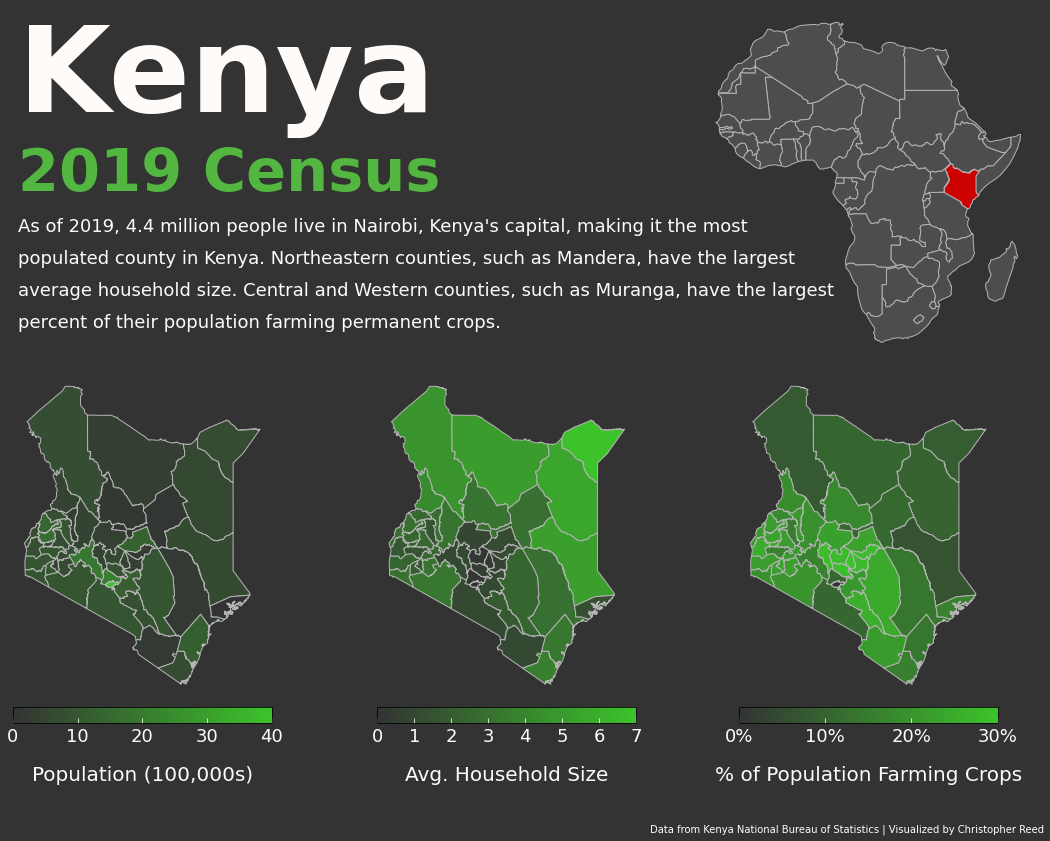

In [11]:
####################################
## GRID SPEC TO MAKE FIG AND AXES ##
####################################

fig = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig.add_gridspec(2, 3)

# Slice gs into axes
ax_africa = fig.add_subplot(gs[0, 2])
ax_pop = fig.add_subplot(gs[1, 0])
ax_house = fig.add_subplot(gs[1, 1])
ax_farm = fig.add_subplot(gs[1, 2])

# Use this color map for all geopandas and colorbars
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#333333', '#3cc32b'], N = 300)

##############################
## AFRICA W KENYA HIGHLIGHT ##
##############################

# Filter world from gpd to Kenya and Africa
africa = world[world['continent'] == 'Africa']
kenya = world[world['name'] == 'Kenya']

# Plot Africa and Kenya
africa.plot(ax = ax_africa,
            color = '#4d4d4d',
            edgecolor = '#b4b4b4')
kenya.plot(ax = ax_africa,
           color ='#cc0202',
           edgecolor = '#b4b4b4')


#####################
## POPULATION MAP  ##
#####################

# Geopandas plot
df_complete_data.plot(column = 'population_hundred_thousand',
                      edgecolor = '#b4b4b4',
                      cmap = cmap,
                      ax = ax_pop)

# Set axis for colorbar
divider_pop = make_axes_locatable(ax_pop)
cax_pop = divider_pop.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

# Make color bar
vmax_pop = df_complete_data['population_hundred_thousand'].max()
mappable_pop = plt.cm.ScalarMappable(cmap = cmap,
                                      norm = plt.Normalize(vmin = 0,
                                                           vmax = 10 * round(vmax_pop/10)))

# Get colorbar into matplotlib
cbar_pop = fig.colorbar(mappable_pop,
                        cax = cax_pop,
                        orientation = 'horizontal')

# Format color bar using normal matplotlib style
cbar_pop.set_ticks(np.arange(0, (10 * round(vmax_pop/10)) + 10, 10))
cbar_pop.ax.tick_params(direction = 'in',
                        color = '#fffbf9',
                        length = 5,
                        labelsize = 18,
                        labelcolor = '#fffbf9')

# Colorbar title
cbar_pop.ax.set_xlabel('Population (100,000s)',
                       fontsize = 20,
                       labelpad = 20,
                       color = '#fffbf9')

###################
## HOUSEHOLD MAP ##
###################


# Geopandas plot
df_complete_data.plot(column = 'average_household_size',
                      edgecolor = '#b4b4b4',
                      cmap = cmap,
                      ax = ax_house)

# Set axis for colorbar
divider_house = make_axes_locatable(ax_house)
cax_house = divider_house.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

# Make color bar
vmax_house = df_complete_data['average_household_size'].max()
mappable_house = plt.cm.ScalarMappable(cmap = cmap,
                                       norm = plt.Normalize(vmin = 0,
                                                            vmax = round(vmax_house)))

# Get colorbar into matplotlib
cbar_house = fig.colorbar(mappable_house,
                          cax = cax_house,
                          orientation = 'horizontal')

# Format color bar using normal matplotlib style
cbar_house.set_ticks(np.arange(0, round(vmax_house) + 1, 1))
cbar_house.ax.tick_params(direction = 'in',
                          color = '#fffbf9',
                          length = 5,
                          labelsize = 18,
                          labelcolor = '#fffbf9')
# Colorbar title
cbar_house.ax.set_xlabel('Avg. Household Size',
                         fontsize = 20,
                         labelpad = 20,
                         color = '#fffbf9')


######################
## PROP FARMING MAP ##
######################

# Geopandas plot
df_complete_data.plot(column = 'prop_farming',
                      edgecolor = '#b4b4b4',
                      cmap = cmap,
                      ax = ax_farm)

# Set axis for colorbar
divider_farm = make_axes_locatable(ax_farm)
cax_farm = divider_farm.append_axes('bottom',
                            size = '5%',
                            pad=0.1)

# Make color bar
# Doing this bc didn't want to deal with rounding decimals
vmax_farm = 0.30
mappable_farm = plt.cm.ScalarMappable(cmap = cmap,
                                      norm = plt.Normalize(vmin = 0,
                                                           vmax = vmax_farm))

# Get colorbar into matplotlib
cbar_farm = fig.colorbar(mappable_farm,
                         cax = cax_farm,
                         orientation = 'horizontal',
                         format = ticker.PercentFormatter(xmax = 1,
                                                          decimals = 0))

# Format color bar using normal matplotlib style
cbar_farm.set_ticks(np.arange(0,vmax_farm + 0.10, 0.10))
cbar_farm.ax.tick_params(direction = 'in',
                         color = '#fffbf9',
                         length = 5,
                         labelsize = 18,
                         labelcolor = '#fffbf9')

# Colorbar title
cbar_farm.ax.set_xlabel('% of Population Farming Crops',
                        fontsize = 20,
                        labelpad = 20,
                        color = '#fffbf9')


##########
## TEXT ##
##########

# Kenya
fig.text(x = 0.05, y = 0.85,
         s = 'Kenya',
         fontsize = 120,
         weight = 'heavy',
         color = '#fffbf9')

# 2019 Census
fig.text(x = 0.05, y = 0.74,
         s = '2019 Census',
         fontsize = 59,
         weight = 'heavy',
         color = '#53b641')

# Desc
description = """As of 2019, 4.4 million people live in Nairobi, Kenya's capital, making it the most
populated county in Kenya. Northeastern counties, such as Mandera, have the largest
average household size. Central and Western counties, such as Muranga, have the largest 
percent of their population farming permanent crops."""

fig.text(x = 0.05, y = 0.55,
         s = description,
         fontsize = 18,
         color = '#fffbf9',
         linespacing = 2)

# Credits
fig.text(x = 1.0, y = -0.15,
         s = 'Data from Kenya National Bureau of Statistics | Visualized by Christopher Reed',
         color = '#fffbf9',
         ha = 'right',
         fontsize = 10,
         linespacing = 1.5)

#################
## EXTRA STEPS ##
#################

# Turn off all axes
ax_africa.axis('off')
ax_pop.axis('off')
ax_house.axis('off')
ax_farm.axis('off')

# Background color
fig.set_facecolor('#333333')

# For high res change the dpi
plt.savefig('Kenya Census', facecolor = '#333333', bbox_inches = 'tight', dpi = 1200)